In [71]:
import inspect
import re
from typing import Callable, List, Optional, Union

import numpy as np
import torch

import diffusers
import PIL
from diffusers import SchedulerMixin, StableDiffusionPipeline
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput, StableDiffusionSafetyChecker
from diffusers.utils import deprecate, logging
from packaging import version
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

re_attention = re.compile(
    r"""
\\\(|
\\\)|
\\\[|
\\]|
\\\\|
\\|
\(|
\[|
:([+-]?[.\d]+)\)|
\)|
]|
[^\\()\[\]:]+|
:
""",
    re.X,
)


def parse_prompt_attention(text):
    """
    Parses a string with attention tokens and returns a list of pairs: text and its associated weight.
    Accepted tokens are:
      (abc) - increases attention to abc by a multiplier of 1.1
      (abc:3.12) - increases attention to abc by a multiplier of 3.12
      [abc] - decreases attention to abc by a multiplier of 1.1
      \( - literal character '('
      \[ - literal character '['
      \) - literal character ')'
      \] - literal character ']'
      \\ - literal character '\'
      anything else - just text
    >>> parse_prompt_attention('normal text')
    [['normal text', 1.0]]
    >>> parse_prompt_attention('an (important) word')
    [['an ', 1.0], ['important', 1.1], [' word', 1.0]]
    >>> parse_prompt_attention('(unbalanced')
    [['unbalanced', 1.1]]
    >>> parse_prompt_attention('\(literal\]')
    [['(literal]', 1.0]]
    >>> parse_prompt_attention('(unnecessary)(parens)')
    [['unnecessaryparens', 1.1]]
    >>> parse_prompt_attention('a (((house:1.3)) [on] a (hill:0.5), sun, (((sky))).')
    [['a ', 1.0],
     ['house', 1.5730000000000004],
     [' ', 1.1],
     ['on', 1.0],
     [' a ', 1.1],
     ['hill', 0.55],
     [', sun, ', 1.1],
     ['sky', 1.4641000000000006],
     ['.', 1.1]]
    """

    res = []
    round_brackets = []
    square_brackets = []

    round_bracket_multiplier = 1.1
    square_bracket_multiplier = 1 / 1.1

    def multiply_range(start_position, multiplier):
        for p in range(start_position, len(res)):
            res[p][1] *= multiplier

    for m in re_attention.finditer(text):
        text = m.group(0)
        weight = m.group(1)

        if text.startswith("\\"):
            res.append([text[1:], 1.0])
        elif text == "(":
            round_brackets.append(len(res))
        elif text == "[":
            square_brackets.append(len(res))
        elif weight is not None and len(round_brackets) > 0:
            multiply_range(round_brackets.pop(), float(weight))
        elif text == ")" and len(round_brackets) > 0:
            multiply_range(round_brackets.pop(), round_bracket_multiplier)
        elif text == "]" and len(square_brackets) > 0:
            multiply_range(square_brackets.pop(), square_bracket_multiplier)
        else:
            res.append([text, 1.0])

    for pos in round_brackets:
        multiply_range(pos, round_bracket_multiplier)

    for pos in square_brackets:
        multiply_range(pos, square_bracket_multiplier)

    if len(res) == 0:
        res = [["", 1.0]]

    # merge runs of identical weights
    i = 0
    while i + 1 < len(res):
        if res[i][1] == res[i + 1][1]:
            res[i][0] += res[i + 1][0]
            res.pop(i + 1)
        else:
            i += 1

    return res


def get_prompts_with_weights(prompt: List[str], max_length: int):
    r"""
    Tokenize a list of prompts and return its tokens with weights of each token.
    No padding, starting or ending token is included.
    """
    tokens = []
    weights = []
    truncated = False
    for text in prompt:
        texts_and_weights = parse_prompt_attention(text)
        text_token = []
        text_weight = []
        for word, weight in texts_and_weights:
            # tokenize and discard the starting and the ending token
            token = tokenizer(word).input_ids[1:-1]
            text_token += token
            # copy the weight by length of token
            text_weight += [weight] * len(token)
            # stop if the text is too long (longer than truncation limit)
            if len(text_token) > max_length:
                truncated = True
                break
        # truncate
        if len(text_token) > max_length:
            truncated = True
            text_token = text_token[:max_length]
            text_weight = text_weight[:max_length]
        tokens.append(text_token)
        weights.append(text_weight)
    if truncated:
        ...
        #logger.warning("Prompt was truncated. Try to shorten the prompt or increase max_embeddings_multiples")
    return tokens, weights


def pad_tokens_and_weights(tokens, weights, max_length, bos, eos, no_boseos_middle=True, chunk_length=77):
    r"""
    Pad the tokens (with starting and ending tokens) and weights (with 1.0) to max_length.
    """
    max_embeddings_multiples = (max_length - 2) // (chunk_length - 2)
    weights_length = max_length if no_boseos_middle else max_embeddings_multiples * chunk_length
    for i in range(len(tokens)):
        tokens[i] = [bos] + tokens[i] + [eos] * (max_length - 1 - len(tokens[i]))
        if no_boseos_middle:
            weights[i] = [1.0] + weights[i] + [1.0] * (max_length - 1 - len(weights[i]))
        else:
            w = []
            if len(weights[i]) == 0:
                w = [1.0] * weights_length
            else:
                for j in range(max_embeddings_multiples):
                    w.append(1.0)  # weight for starting token in this chunk
                    w += weights[i][j * (chunk_length - 2) : min(len(weights[i]), (j + 1) * (chunk_length - 2))]
                    w.append(1.0)  # weight for ending token in this chunk
                w += [1.0] * (weights_length - len(w))
            weights[i] = w[:]

    return tokens, weights


def get_unweighted_text_embeddings(
    text_encoder,
    text_input: torch.Tensor,
    chunk_length: int,
    no_boseos_middle: Optional[bool] = True,
):
    """
    When the length of tokens is a multiple of the capacity of the text encoder,
    it should be split into chunks and sent to the text encoder individually.
    """
    max_embeddings_multiples = (text_input.shape[1] - 2) // (chunk_length - 2)
    if max_embeddings_multiples > 1:
        text_embeddings = []
        for i in range(max_embeddings_multiples):
            # extract the i-th chunk
            text_input_chunk = text_input[:, i * (chunk_length - 2) : (i + 1) * (chunk_length - 2) + 2].clone()

            # cover the head and the tail by the starting and the ending tokens
            text_input_chunk[:, 0] = text_input[0, 0]
            text_input_chunk[:, -1] = text_input[0, -1]
            text_embedding = text_encoder(text_input_chunk)[0]

            if no_boseos_middle:
                if i == 0:
                    # discard the ending token
                    text_embedding = text_embedding[:, :-1]
                elif i == max_embeddings_multiples - 1:
                    # discard the starting token
                    text_embedding = text_embedding[:, 1:]
                else:
                    # discard both starting and ending tokens
                    text_embedding = text_embedding[:, 1:-1]

            text_embeddings.append(text_embedding)
        text_embeddings = torch.concat(text_embeddings, axis=1)
    else:
        text_embeddings = text_encoder(text_input)[0]
    return text_embeddings


def get_weighted_text_embeddings(
    prompt: Union[str, List[str]],
    uncond_prompt: Optional[Union[str, List[str]]] = None,
    max_embeddings_multiples: Optional[int] = 3,
    no_boseos_middle: Optional[bool] = False,
    skip_parsing: Optional[bool] = False,
    skip_weighting: Optional[bool] = False,
    **kwargs,
):
    r"""
    Prompts can be assigned with local weights using brackets. For example,
    prompt 'A (very beautiful) masterpiece' highlights the words 'very beautiful',
    and the embedding tokens corresponding to the words get multiplied by a constant, 1.1.
    Also, to regularize of the embedding, the weighted embedding would be scaled to preserve the original mean.
    Args:
        pipe (`StableDiffusionPipeline`):
            Pipe to provide access to the tokenizer and the text encoder.
        prompt (`str` or `List[str]`):
            The prompt or prompts to guide the image generation.
        uncond_prompt (`str` or `List[str]`):
            The unconditional prompt or prompts for guide the image generation. If unconditional prompt
            is provided, the embeddings of prompt and uncond_prompt are concatenated.
        max_embeddings_multiples (`int`, *optional*, defaults to `3`):
            The max multiple length of prompt embeddings compared to the max output length of text encoder.
        no_boseos_middle (`bool`, *optional*, defaults to `False`):
            If the length of text token is multiples of the capacity of text encoder, whether reserve the starting and
            ending token in each of the chunk in the middle.
        skip_parsing (`bool`, *optional*, defaults to `False`):
            Skip the parsing of brackets.
        skip_weighting (`bool`, *optional*, defaults to `False`):
            Skip the weighting. When the parsing is skipped, it is forced True.
    """
    max_length = (tokenizer.model_max_length - 2) * max_embeddings_multiples + 2
    if isinstance(prompt, str):
        prompt = [prompt]

    if not skip_parsing:
        prompt_tokens, prompt_weights = get_prompts_with_weights(prompt, max_length - 2)
        if uncond_prompt is not None:
            if isinstance(uncond_prompt, str):
                uncond_prompt = [uncond_prompt]
            uncond_tokens, uncond_weights = get_prompts_with_weights(uncond_prompt, max_length - 2)
    else:
        prompt_tokens = [
            token[1:-1] for token in tokenizer(prompt, max_length=max_length, truncation=True).input_ids
        ]
        prompt_weights = [[1.0] * len(token) for token in prompt_tokens]
        if uncond_prompt is not None:
            if isinstance(uncond_prompt, str):
                uncond_prompt = [uncond_prompt]
            uncond_tokens = [
                token[1:-1]
                for token in tokenizer(uncond_prompt, max_length=max_length, truncation=True).input_ids
            ]
            uncond_weights = [[1.0] * len(token) for token in uncond_tokens]

    # round up the longest length of tokens to a multiple of (model_max_length - 2)
    max_length = max([len(token) for token in prompt_tokens])
    if uncond_prompt is not None:
        max_length = max(max_length, max([len(token) for token in uncond_tokens]))

    max_embeddings_multiples = min(
        max_embeddings_multiples,
        (max_length - 1) // (tokenizer.model_max_length - 2) + 1,
    )
    max_embeddings_multiples = max(1, max_embeddings_multiples)
    max_length = (tokenizer.model_max_length - 2) * max_embeddings_multiples + 2

    # pad the length of tokens and weights
    bos = tokenizer.bos_token_id
    eos = tokenizer.eos_token_id
    prompt_tokens, prompt_weights = pad_tokens_and_weights(
        prompt_tokens,
        prompt_weights,
        max_length,
        bos,
        eos,
        no_boseos_middle=no_boseos_middle,
        chunk_length=tokenizer.model_max_length,
    )
    prompt_tokens = torch.tensor(prompt_tokens, dtype=torch.long, device=device)
    if uncond_prompt is not None:
        uncond_tokens, uncond_weights = pad_tokens_and_weights(
            uncond_tokens,
            uncond_weights,
            max_length,
            bos,
            eos,
            no_boseos_middle=no_boseos_middle,
            chunk_length=tokenizer.model_max_length,
        )
        uncond_tokens = torch.tensor(uncond_tokens, dtype=torch.long, device=device)

    # get the embeddings
    text_embeddings = get_unweighted_text_embeddings(
        text_encoder,
        prompt_tokens,
        tokenizer.model_max_length,
        no_boseos_middle=no_boseos_middle,
    )
    prompt_weights = torch.tensor(prompt_weights, dtype=text_embeddings.dtype, device=device)
    if uncond_prompt is not None:
        uncond_embeddings = get_unweighted_text_embeddings(
            text_encoder,
            uncond_tokens,
            tokenizer.model_max_length,
            no_boseos_middle=no_boseos_middle,
        )
        uncond_weights = torch.tensor(uncond_weights, dtype=uncond_embeddings.dtype, device=device)

    # assign weights to the prompts and normalize in the sense of mean
    # TODO: should we normalize by chunk or in a whole (current implementation)?
    if (not skip_parsing) and (not skip_weighting):
        previous_mean = text_embeddings.float().mean(axis=[-2, -1]).to(text_embeddings.dtype)
        text_embeddings *= prompt_weights.unsqueeze(-1)
        current_mean = text_embeddings.float().mean(axis=[-2, -1]).to(text_embeddings.dtype)
        text_embeddings *= (previous_mean / current_mean).unsqueeze(-1).unsqueeze(-1)
        if uncond_prompt is not None:
            previous_mean = uncond_embeddings.float().mean(axis=[-2, -1]).to(uncond_embeddings.dtype)
            uncond_embeddings *= uncond_weights.unsqueeze(-1)
            current_mean = uncond_embeddings.float().mean(axis=[-2, -1]).to(uncond_embeddings.dtype)
            uncond_embeddings *= (previous_mean / current_mean).unsqueeze(-1).unsqueeze(-1)

    if uncond_prompt is not None:
        return text_embeddings, uncond_embeddings
    return text_embeddings, None


def preprocess_image(image):
    w, h = map(lambda x: x - x % 32, (opt.W, opt.H))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.Resampling.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0

    

The system cannot find the path specified.


Outputs will be saved to /content/images/
Using the seed 1302930215


The syntax of the command is incorrect.
C:\Users\Cad\AppData\Local\Temp\ipykernel_11900\3590754892.py:345: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize(shape, resample=PIL.Image.LANCZOS)


100%|██████████| 12/12 [00:02<00:00,  4.04it/s]


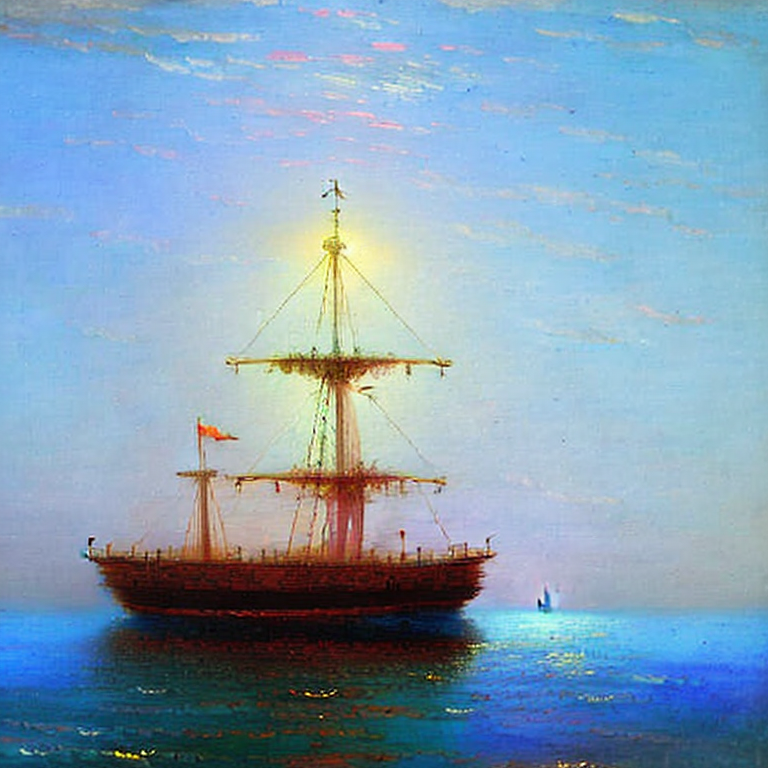

In [99]:
from datetime import datetime

res_dict = {"Square 512x512 (default, good for most models)": [512,512],
            "Landscape 768x512": [768,512],
            "Portrait 512x768": [512,768],
            "Square 768x768 (good for 768 models)": [768,768],
            "Landscape 1152x768 (does not work on free colab)": [1152,768],
            "Portrait 768x1152 (does not work on free colab)":[768,1152]}
#@markdown ### <b>Model Choice </b>
model_choice = "Stable Diffusion 2.0 (768)" #@param ["Stable Diffusion 1.4","Stable Diffusion 1.5","Stable Diffusion 2.0 (512)","Stable Diffusion 2.0 (768)","Stable Diffusion 2.1 (512)","Stable Diffusion 2.1 (768)","Pokemon Diffusion","Waifu Diffusion 1.3","Anything v3.0","seek.art_MEGA","Robo Diffusion","Inkpunk Diffusion","Classic Animation Diffusion","Modern Animation Diffusion","Ghibli Diffusion","Van Gogh Diffusion","Openjourney","Dreamlike Diffusion","Future Diffusion","Gigafractal Diffusion","Stable Diffusion 1.4 with VAE","Stable Diffusion 1.5 with VAE"] {type:"string"}

model_dict = {
  "Stable Diffusion 1.4": {
    "url": "CompVis/stable-diffusion-v1-4",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "",
    "prediction": "epsilon"
  },
  "Stable Diffusion 1.5": {
    "url": "runwayml/stable-diffusion-v1-5",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "",
    "prediction": "epsilon"
  },
  "Stable Diffusion 2.0 (512)": {
    "url": "stabilityai/stable-diffusion-2-base",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "",
    "prediction": "epsilon"
  },
  "Stable Diffusion 2.0 (768)": {
    "url": "stabilityai/stable-diffusion-2",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "",
    "prediction": "v_prediction"
  },
  "Stable Diffusion 2.1 (512)": {
    "url": "stabilityai/stable-diffusion-2-1-base",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "",
    "prediction": "epsilon"
  },
  "Stable Diffusion 2.1 (768)": {
    "url": "stabilityai/stable-diffusion-2-1",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "",
    "prediction": "v_prediction"
  },
  "Pokemon Diffusion": {
    "url": "justinpinkney/pokemon-stable-diffusion",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "",
    "prediction": "epsilon"
  },
  "Waifu Diffusion 1.3": {
    "url": "hakurei/waifu-diffusion-v1-3",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "",
    "prediction": "epsilon"
  },
  "Anything v3.0": {
    "url": "Linaqruf/anything-v3.0",
    "requires_hf_login": False,
    "vae": {
      "url": "Linaqruf/anything-v3.0",
      "requires_hf_login": False,
      "filename": "anything-V3.0.vae.pt"
    },
    "keyword": "",
    "prediction": "epsilon"
  },
  "seek.art_MEGA": {
    "url": "coreco/seek.art_MEGA",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "",
    "prediction": "epsilon"
  },
  "Robo Diffusion": {
    "url": "nousr/robo-diffusion",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "nousr robot",
    "prediction": "epsilon"
  },
  "Inkpunk Diffusion": {
    "url": "Envvi/Inkpunk-Diffusion",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "nvinkpunk",
    "prediction": "epsilon"
  },
  "Classic Animation Diffusion": {
    "url": "nitrosocke/classic-anim-diffusion",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "classic disney style",
    "prediction": "epsilon"
  },
  "Modern Animation Diffusion": {
    "url": "nitrosocke/mo-di-diffusion",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "modern disney style",
    "prediction": "epsilon"
  },
  "Ghibli Diffusion": {
    "url": "nitrosocke/Ghibli-Diffusion",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "ghibli style",
    "prediction": "epsilon"
  },
  "Van Gogh Diffusion": {
    "url": "dallinmackay/Van-Gogh-diffusion",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "lvngvncnt",
    "prediction": "epsilon"
  },
  "Openjourney": {
    "url": "prompthero/openjourney",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "mdjrny-v4 style",
    "prediction": "epsilon"
  },
  "Dreamlike Diffusion": {
    "url": "dreamlike-art/dreamlike-diffusion-1.0",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "dreamlikeart",
    "prediction": "epsilon"
  },
  "Future Diffusion": {
    "url": "nitrosocke/Future-Diffusion",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "future style",
    "prediction": "epsilon"
  },
  "Gigafractal Diffusion": {
    "url": "kabachuha/gigafractal2-diffusion",
    "requires_hf_login": False,
    "vae": "",
    "keyword": "gigafractal artstyle",
    "prediction": "v_prediction"
  },
  "Stable Diffusion 1.4 with VAE": {
    "url": "bstddev/sd-v1-4",
    "requires_hf_login": False,
    "vae": {
      "url": "stabilityai/sd-vae-ft-mse-original",
      "requires_hf_login": False,
    },
    "keyword": "",
    "prediction": "epsilon"
  },
  "Stable Diffusion 1.5 with VAE": {
    "url": "runwayml/stable-diffusion-v1-5",
    "requires_hf_login": False,
    "vae": {
      "url": "stabilityai/sd-vae-ft-mse-original",
      "requires_hf_login": False,
    },
    "keyword": "",
    "prediction": "epsilon"
  }
}

def process_prompt(prompt):
  result = prompt
  keyword = model_dict[model_choice]["keyword"]
  if keyword != "" and keyword not in prompt:
      result = f"({keyword}:1), {result}"

  return result

# def latents_to_pil(latents):
#     latents = (1 / 0.18215) * latents
#     with torch.no_grad():
#         image = vae.decode(latents.half())['sample']
#     image = (image / 2 + 0.5).clamp(0, 1)
#     image = image.detach().permute(0, 2, 3, 1).cpu().numpy()
#     images = (image * 255).round().astype("uint8")
#     pil_images = [PIL.Image.fromarray(image) for image in images]
#     return pil_images

def decode_latents(latents):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [PIL.Image.fromarray(image) for image in images]
    return pil_images

def prepare_latents(image, timestep, batch_size, height, width, dtype, device, latents=None):
    vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)
    if image is None:
        shape = (
            batch_size,
            unet.in_channels,
            height // vae_scale_factor,
            width // vae_scale_factor,
        )

        if latents is None:
            if device.type == "mps":
                # randn does not work reproducibly on mps
                latents = torch.randn(shape, device="cpu", dtype=dtype).to(device)
            else:
                latents = torch.randn(shape, device=device, dtype=dtype)
        else:
            if latents.shape != shape:
                raise ValueError(f"Unexpected latents shape, got {latents.shape}, expected {shape}")
            latents = latents.to(device)

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * scheduler.init_noise_sigma
        return latents, None, None
    else:
        init_latent_dist = vae.encode(image).latent_dist
        init_latents = init_latent_dist.sample()
        init_latents = 0.18215 * init_latents
        init_latents = torch.cat([init_latents] * batch_size, dim=0)
        init_latents_orig = init_latents
        shape = init_latents.shape

        # add noise to latents using the timesteps

        noise = torch.randn(shape, device=device, dtype=dtype)
        latents = scheduler.add_noise(init_latents, noise, timestep)
        return latents, init_latents_orig, noise

def get_timesteps(num_inference_steps, is_text2img):
    if is_text2img:
        return scheduler.timesteps.to(device), num_inference_steps
    else:
        # get the original timestep using init_timestep
        offset = scheduler.config.get("steps_offset", 0)
        init_timestep = int(num_inference_steps * opt.strength) + offset
        init_timestep = min(init_timestep, num_inference_steps)

        t_start = max(num_inference_steps - init_timestep + offset, 0)
        timesteps = scheduler.timesteps[t_start:].to(device)
        return timesteps, num_inference_steps - t_start

#@markdown ### <b>Image Generation</b><br>
#@markdown See previous cell for setting explanations
prompt = "A sailing ship on a prismatic ocean by Ivan Aivazovsky" #@param{type:"string"}
negative = "" #@param{type: 'string'}
resolution = "Custom (Select this and put width and height below)" #@param ["Custom (Select this and put width and height below)", "Square 512x512 (default, good for most models)", "Landscape 768x512", "Portrait 512x768", "Square 768x768 (good for 768 models)", "Landscape 1152x768 (does not work on free colab)", "Portrait 768x1152 (does not work on free colab)"] {type:"string"}

#width_height = [768,512] #@param{type: 'raw'}
#@markdown <br>
#@markdown <b>Advanced Settings</b>
width_height_if_custom_is_selected = [768, 768] #@param{type: 'raw'}
steps = 15 #@param {type:"integer"}
samples_per_batch = 1
number_of_images = 1 #@param {type:"integer"}
seed = -1 #@param {type:"integer"}
sampler = "DPMSolver++ (2S)" #@param ["Euler a", "Euler", "KLMS",  "DPMSolver++ (2S)", "DPMSolver++ (2M)"] {type:"string"}
batch_name = ""
batch_name = batch_name + datetime.now().strftime("%H:%M:%S")
guidance_scale = 10 #@param {type:"slider", min:0, max:20, step:0.5}
ddim_eta = 0.0
zoom = False
width_height = width_height_if_custom_is_selected if resolution == "Custom (Select this and put width and height below)" else res_dict[resolution]
tiling = False #@param {type: "boolean"}
#@markdown If `tiling` results look poor, double the amount of steps from non-tiling.
#@markdown <br>
#@markdown <br>
#@markdown
#@markdown ---

#@markdown <b>Init image</b><br>
init_image_or_folder = "https://static.wikia.nocookie.net/patrickobrian/images/0/0e/Master_commander_hms_surpri.jpg" #@param {type:"string"}
denoising_strength = 0.85 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
#@markdown <br>
#@markdown
#@markdown ---

#@markdown <b>Upscaling</b><br>

upscale_results = True #@param {type: 'boolean'}
detailing = 1 #@param {type:"slider", min:1, max:4, step:1}
upscale_strength = 0 #@param {type:"slider", min:0.0, max:1.0, step:0.05}

import os
import random
import math
import random

# try:
#   import torch
#   from diffusers import DiffusionPipeline
#   from diffusers import EulerAncestralDiscreteScheduler, EulerDiscreteScheduler, LMSDiscreteScheduler, DPMSolverSinglestepScheduler, DPMSolverMultistepScheduler
#   from PIL import Image
# except ImportError as e:
!pip3 install torch torchvision torchaudio diffusers transformers accelerate scipy pillow tqdm requests --extra-index-url https://download.pytorch.org/whl/cu116 > /dev/null
outputs_path = "/content/images/"
!mkdir -p $outputs_path
print(f"Outputs will be saved to {outputs_path}")
import requests
import torch
from tqdm import tqdm
import PIL
import numpy as np
from PIL import Image
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import DiffusionPipeline, AutoencoderKL, UNet2DConditionModel
from diffusers import EulerAncestralDiscreteScheduler, EulerDiscreteScheduler, LMSDiscreteScheduler, DPMSolverSinglestepScheduler, DPMSolverMultistepScheduler
from diffusers import StableDiffusionImg2ImgPipeline

def set_seed(seed):
  seed = random.randint(0, 2**32) if seed < 0 else seed
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  print(f"Using the seed {seed}")
  return seed


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def load_img(path, shape):
    if path.startswith('http://') or path.startswith('https://'):
        image = Image.open(requests.get(path, stream=True).raw).convert('RGB')
    else:
        if os.path.isdir(path):
            files = [file for file in os.listdir(path) if file.endswith('.png') or file .endswith('.jpg')]
            path = os.path.join(path, random.choice(files))
            print(f"Chose random init image {path}")
        image = Image.open(path).convert('RGB')
    image = image.resize(shape, resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float16) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

class Config():
  def __init__(self):
      self.model_name = model_dict[model_choice]["url"]
      self.vae_name = model_dict[model_choice]["url"]
      self.eta = 0.0
      self.steps = 100
      self.fixed_code = True
      self.init_img = None
      self.n_iter = 1
      self.n_samples = 1
      self.outdir = ""
      self.precision = 'autocast'
      self.prompt = ""
      self.negative = ""
      self.sampler = 'klms'
      self.seamless = False
      self.scale = 7.5
      self.seed = 42
      self.strength = 0.75 # strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image
      self.H = 512
      self.W = 512
      self.C = 4
      self.f = 8
      #upscale stuff
      self.passes = 1
      self.gobig_overlap = 128
      self.detail_steps = 150
      self.upscale_strength = 0.3
      self.detail_scale = 10

opt = Config()
batch_idx = 0
sample_idx = 0

recreate = False
try:
  unet
  recreate = model_name != opt.model_name
except NameError as e:
  recreate = True

if recreate:
  #pipe = DiffusionPipeline.from_pretrained(opt.model_name, custom_pipeline="sd_text2img_k_diffusion")
  #pipe = DiffusionPipeline.from_pretrained(opt.model_name, custom_pipeline="lpw_stable_diffusion")
  if model_dict[model_choice]["vae"] != "":
    opt.vae_name = model_dict[model_choice]["vae"]
  vae = AutoencoderKL.from_pretrained(opt.vae_name, subfolder="vae")

  try:
    tokenizer = CLIPTokenizer.from_pretrained(opt.model_name, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(opt.model_name, subfolder="text_encoder")
  except:
      tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
      text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
      print("Could not load CLIP model from repo.")

  unet = UNet2DConditionModel.from_pretrained(opt.model_name, subfolder="unet")

  vae = vae.half().to(device).eval()
  text_encoder = text_encoder.half().to(device).eval()
  unet = unet.half().to(device).eval()

  model_name = opt.model_name


#pipe = pipe.to("cuda")

sampler_dict = {
  "Euler a": {
    "type": "diffusers",
    "sampler": EulerAncestralDiscreteScheduler
  },
  "Euler": {
    "type": "diffusers",
    "sampler": EulerDiscreteScheduler
  },
  "KLMS": {
    "type": "diffusers",
    "sampler": LMSDiscreteScheduler
  },
    "DPMSolver++ (2S)": {
    "type": "diffusers_DPMSolver",
    "sampler": DPMSolverSinglestepScheduler
  },
  "DPMSolver++ (2M)": {
    "type": "diffusers_DPMSolver",
    "sampler": DPMSolverMultistepScheduler
  }
}

# ,
#   "DPM Adaptive": {
#     "type": "k-crowson",
#     "sampler": "sample_dpm_adaptive"
#   },
#   "DPM Fast": {
#     "type": "k-crowson",
#     "sampler": "sample_dpm_fast"
#   }


batches = number_of_images
opt.seamless = tiling
opt.steps = steps
opt.n_iter = 1
opt.n_samples = samples_per_batch
opt.outdir = os.path.join(outputs_path, batch_name)
opt.prompt = process_prompt(prompt)
opt.negative = negative
opt.sampler = sampler
opt.scale = guidance_scale
opt.seed = set_seed(seed)
opt.strength = denoising_strength
opt.W, opt.H = map(lambda x: x - x % 64, (width_height[0], width_height[1])) # resize to integer multiple of 64
opt.init_img = load_img(init_image_or_folder, shape=(opt.W, opt.H)) if init_image_or_folder != "" else None
#upscale stuff
opt.upscale = upscale_results
opt.passes = 1
opt.gobig_overlap = 128
#opt.detail_steps = 150
opt.detail_steps = steps*detailing
opt.upscale_strength = max(0.0, min(1.0, 1.0 - upscale_strength))
opt.detail_scale = 10
display(opt)

if sampler_dict[sampler]["type"] == "diffusers":
  scheduler = sampler_dict[sampler]["sampler"](
    num_train_timesteps = 1000, 
    beta_start= 0.0001, 
    beta_end = 0.02, 
    beta_schedule = 'linear', 
    trained_betas = None, 
    prediction_type = model_dict[model_choice]["prediction"]
    ) 
  #from_pretrained(opt.model_url, subfolder="scheduler")
elif sampler_dict[sampler]["type"] == "diffusers_DPMSolver":
  scheduler = sampler_dict[sampler]["sampler"](
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000,
        trained_betas=None,
        prediction_type=model_dict[model_choice]["prediction"],
        thresholding=False,
        algorithm_type="dpmsolver++",
        solver_type="midpoint",
        lower_order_final=True,
        solver_order=3
    )
# elif sampler_dict[sampler]["type"] == "k-crowson":
#   pipe.set_scheduler(sampler_dict[sampler]["sampler"])

scheduler.set_timesteps(steps)

prompt_options = {
  "prompt": opt.prompt,
  "negative_prompt": None if opt.negative == "" else opt.negative,
  # "height": opt.H,
  # "width": opt.W,
  "num_inference_steps": opt.steps,
  "guidance_scale": opt.scale,
  "num_images_per_prompt": 1,
  "eta": opt.eta
}

def fix_steps(opt):
  estimated_steps = math.floor(opt.strength*opt.steps)
  if estimated_steps == 0:
    estimated_steps += 1
  if estimated_steps == opt.strength:
    estimated_steps -= 1
  
#### generation stuff

unet.set_attention_slice("auto")

def encode_prompt():
  num_images_per_prompt = 1
  batch_size = len(opt.prompt) if isinstance(opt.prompt, list) else 1
  negative_prompt = [opt.negative] * batch_size

  text_embeddings, uncond_embeddings = get_weighted_text_embeddings(
            prompt=prompt,
            uncond_prompt=negative_prompt,
            max_embeddings_multiples=3,
        )
  bs_embed, seq_len, _ = text_embeddings.shape
  text_embeddings = text_embeddings.repeat(1, num_images_per_prompt, 1)
  text_embeddings = text_embeddings.view(bs_embed * num_images_per_prompt, seq_len, -1)

  bs_embed, seq_len, _ = uncond_embeddings.shape
  uncond_embeddings = uncond_embeddings.repeat(1, num_images_per_prompt, 1)
  uncond_embeddings = uncond_embeddings.view(bs_embed * num_images_per_prompt, seq_len, -1)
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

  return text_embeddings

# def generate():
#   with torch.no_grad():
#     with torch.autocast("cuda"):
#       if opt.init_img != None: #if img2img
#         init_image = opt.init_img.cuda().half()
#         init_latent_dist = vae.encode(init_image).latent_dist

#         init_latents = init_latent_dist.sample()
#         init_latents = 0.18215 * init_latents

#         # get the original timestep using init_timestep
#         offset = scheduler.config.get("steps_offset", 0)
#         init_timestep = int(opt.steps * opt.strength) + offset
#         init_timestep = min(init_timestep, opt.steps)
#         timesteps = scheduler.timesteps[-init_timestep]
#         timesteps = torch.tensor([timesteps], device='cuda')

#         noise = torch.randn(init_latents.shape, device='cuda', dtype=torch.half)
#         latents = scheduler.add_noise(init_latents, noise, timesteps)

#         t_start = max(opt.steps - init_timestep + offset, 0)
#         timesteps = scheduler.timesteps[t_start:].cuda()
#         pbar = tqdm(enumerate(timesteps), total=len(timesteps))
#       else:
#         latents = torch.randn(1, 4, opt.H // 8, opt.W // 8)
#         latents = latents.to(device)
#         latents = latents * scheduler.init_noise_sigma
#         pbar = tqdm(enumerate(scheduler.timesteps), total=opt.steps)
      
#       text_embeddings = _encode_prompt()
#       # tokens_prompt = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
#       # tokens_negative = tokenizer(negative, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
#       # prompt_embedding = text_encoder(tokens_prompt.input_ids.to(device))[0]
#       # negative_embedding = text_encoder(tokens_negative.input_ids.to(device))[0]
    
#       for i, t in pbar:
#         # jankiest lines of code you will *ever* see
#         if sampler_dict[sampler]["type"] == "diffusers":
#             sigma = scheduler.sigmas[i]
#         elif sampler_dict[sampler]["type"] == "diffusers_DPMSolver":
#             sigma = scheduler.sigma_t[i]
#         elif sampler_dict[sampler]["type"] == "diffusers_ddim":
#             # temp fix ? idk what it's equivelant is
#             sigma = 1
        
#         model_input = scheduler.scale_model_input(latents, t)
#         conditional_input = model_input.clone().detach()
#         unconditional_input = model_input.clone().detach()

#         unconditional_noise_pred = unet(unconditional_input, t, encoder_hidden_states = negative_embedding)['sample']
#         conditional_noise_pred = unet(conditional_input, t, encoder_hidden_states = prompt_embedding)['sample']
#         noise_pred = unconditional_noise_pred + opt.scale * (conditional_noise_pred - unconditional_noise_pred)
#         latents = scheduler.step(noise_pred, t, latents)["prev_sample"]

#   latents_to_pil(latents)[0].save("temp.png")
#   display(Image.open("temp.png"))

def generate():
  num_images_per_prompt = 1
  with torch.no_grad():
    with torch.autocast("cuda"):
      if opt.init_img != None: #if img2img
        image = opt.init_img.cuda()
      else:
        image = None
      
      text_embeddings = encode_prompt()
      dtype = text_embeddings.dtype

      scheduler.set_timesteps(opt.steps, device=device)
      timesteps, num_inference_steps = get_timesteps(opt.steps, (opt.init_img == None))
      latent_timestep = timesteps[:1].repeat(1 * num_images_per_prompt)

      latents, init_latents_orig, noise = prepare_latents(image, 
      latent_timestep, 
      1 * num_images_per_prompt,
      opt.H,
      opt.W,
      dtype,
      device,
      None)

      for i, t in tqdm(enumerate(timesteps), total=len(timesteps)):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

      # 9. Post-processing
      image = decode_latents(latents)[0].save("temp.png")
      display(Image.open("temp.png"))

      # tokens_prompt = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
      # tokens_negative = tokenizer(negative, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
      # prompt_embedding = text_encoder(tokens_prompt.input_ids.to(device))[0]
      # negative_embedding = text_encoder(tokens_negative.input_ids.to(device))[0]
    
  #     for i, t in pbar:
  #       # jankiest lines of code you will *ever* see
  #       if sampler_dict[sampler]["type"] == "diffusers":
  #           sigma = scheduler.sigmas[i]
  #       elif sampler_dict[sampler]["type"] == "diffusers_DPMSolver":
  #           sigma = scheduler.sigma_t[i]
  #       elif sampler_dict[sampler]["type"] == "diffusers_ddim":
  #           # temp fix ? idk what it's equivelant is
  #           sigma = 1
        
  #       model_input = scheduler.scale_model_input(latents, t)
  #       conditional_input = model_input.clone().detach()
  #       unconditional_input = model_input.clone().detach()

  #       unconditional_noise_pred = unet(unconditional_input, t, encoder_hidden_states = negative_embedding)['sample']
  #       conditional_noise_pred = unet(conditional_input, t, encoder_hidden_states = prompt_embedding)['sample']
  #       noise_pred = unconditional_noise_pred + opt.scale * (conditional_noise_pred - unconditional_noise_pred)
  #       latents = scheduler.step(noise_pred, t, latents)["prev_sample"]

  # latents_to_pil(latents)[0].save("temp.png")
  # display(Image.open("temp.png"))

for _b in range(batches):
    generate()
# pipe.enable_attention_slicing()


# # Philpax's ugly hack for dealing with samplers that require multiple steps of output
# try:
#   image = pipe(**prompt_options).images[0]
# except TypeError:
#   prompt_options['num_inference_steps'] += 1
#   image = pipe(**prompt_options).images[0]
# display(opt.prompt)
# display(image)

In [92]:
(opt.init_img != None)

True